# Detector de obiecte cu regresie

Detectorul cu regresie are ca rezultat nu doar prezența unui fragment de față în casetele de grila ci și coordonatele obiectului al cărui centru se află în celula respectivă.

In [1]:
!pip install torchinfo

In [2]:
import google.colab
google.colab.drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.ndimage import grey_dilation
from PIL import Image
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from google.colab import files
from IPython.display import display
import glob
import math
from torchinfo import summary

In [4]:
data_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/DATA/train_face_large_dataset'
model_dir = '/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/Models/Face/Elementary_regression'

In [5]:
images_dir = os.path.join(data_dir, 'images')
labels_dir = os.path.join(data_dir, 'labels')

In [6]:
if os.path.isdir(data_dir):
  print("Data directory exists")
else:
  print("Data directory does not exist")
if os.path.isdir(model_dir):
  print("Model directory exists")
else:
  print("Model directory does not exist")

Data directory exists
Model directory exists


In [7]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [9]:
def collate_fn(batch):
    images, targets = zip(*batch)  # Separate images and labels
    images = torch.stack(images, 0)  # Stack images normally
    return images, list(targets)  # Return targets as a list (variable-length)

In [10]:
class YOLODataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = sorted(glob.glob(os.path.join(img_dir, "*.jpg")) + glob.glob(os.path.join(img_dir, "*.png")))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = os.path.basename(img_path).split(".")[0]
        label_path = os.path.join(self.label_dir, f"{img_name}.txt")

        # Load image with PIL to get its size
        # print(img_path)

        image = Image.open(img_path).convert("RGB")

        # Store the original size of the image before any transformations
        original_width, original_height = image.size

        # Apply transformations if available (such as resizing, etc.)
        if self.transform:
            image = self.transform(image)

        # After the transformation, image is a tensor with shape [C, H, W], so:
        new_width, new_height = image.size(2), image.size(1)  # Access width and height from tensor

        # Load labels (if exists)
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    values = list(map(float, line.strip().split()))
                    boxes.append(values)
        return image, torch.tensor(boxes)

In [ ]:
class YOLOFaceCNN(nn.Module):
    def __init__(self, grid_size=7):
        super(YOLOFaceCNN, self).__init__()
        self.grid_size = grid_size

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 128, kernel_size=1), nn.LeakyReLU(0.1),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 256, kernel_size=1), nn.LeakyReLU(0.1),
            nn.Conv2d(256, 512, kernel_size=3, padding=1), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 14 * 14, 4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.grid_size ** 2 * 5),  # Predicts (p, x, y, w, h) per grid cell
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x.view(-1, self.grid_size, self.grid_size, 5)  # Now predicts bounding boxes


## Funcția de cost

Această funcție de cost (YOLOFaceLoss) este concepută pentru a antrena un model de tip YOLO adaptat pentru detectarea fețelor într-o imagine, unde fiecare celulă a unei grile bidimensionale decide dacă există o față și estimează poziția și dimensiunile acesteia. Funcția ia în considerare atât celulele care conțin fețe, cât și cele care nu conțin, aplicând penalizări diferite în funcție de situație.

Funcția primește ca intrare două tensori: pred (predicțiile modelului) și target (valorile reale), fiecare de dimensiune (batch, grid_size, grid_size, 5), unde cei cinci coeficienți reprezintă: probabilitatea prezenței unei fețe, coordonatele centrului (x, y) și dimensiunile (lățime, înălțime) ale feței în cadrul celulei.

In [ ]:
class YOLOFaceLoss(nn.Module):
    def __init__(self, lambda_coord=2, lambda_noobj=0.02):
        super(YOLOFaceLoss, self).__init__()
        self.lambda_coord = lambda_coord  # Weight for face presence
        self.lambda_noobj = lambda_noobj  # Weight for no-face cells
        self.mse = nn.MSELoss(reduction='sum')  # Mean Squared Error loss (sum for all grid cells)
        self.bce = nn.BCELoss(reduction='sum')  # Binary Cross-Entropy Loss

    def forward(self, pred, target):
        """
        pred: (batch, grid_size, grid_size, 5) - Model predictions
        target: (batch, grid_size, grid_size, 5) - Ground truth (x, y, w, h, confidence)
        """
        # Masks for face and no-face cells
        obj_mask = target[..., 0] > 0  # Cells where a face exists (probability is in the first position)
        no_obj_mask = target[..., 0] == 0  # Cells without a face (probability is in the first position)

        # Coordinate Loss (x, y, w, h)
        coord_loss = 0.0
        if obj_mask.any():  # Only apply loss if there are faces
            coord_loss = self.lambda_coord * self.mse(pred[obj_mask][..., 1:5], target[obj_mask][..., 1:5])

        # Confidence Score Loss (Object cells)
        obj_loss = 0.0
        if obj_mask.any():  # Only apply loss for cells containing faces
            obj_loss = self.bce(pred[obj_mask][..., 0], target[obj_mask][..., 0])

        # Confidence Score Loss (No object cells)
        no_obj_loss = 0.0
        if no_obj_mask.any():  # Only apply loss for cells containing no faces
            no_obj_loss = self.lambda_noobj * self.bce(pred[no_obj_mask][..., 0], target[no_obj_mask][..., 0])

        # Check for NaN values in loss terms
        if math.isnan(coord_loss) or math.isnan(obj_loss) or math.isnan(no_obj_loss):
            print(f"NaN detected in loss! coord_loss: {coord_loss}, obj_loss: {obj_loss}, no_obj_loss: {no_obj_loss}")

        # Return the total loss
        # print(f"coord_loss: {coord_loss}  obj_loss: {obj_loss} no_obj_loss: {no_obj_loss}")
        total_loss = coord_loss + obj_loss + no_obj_loss

        return total_loss, coord_loss, obj_loss, no_obj_loss

In [ ]:
hyperparameters = {
    "learning_rate": 0.0001,
    "epochs": 60,
    "batch_size": 16,
    "grid_size" : 7,
    "lambda_coord": 0.8,
    "lambda_noobj": 0.005,
    "device": str(DEVICE),
    "model_name_root": "yolo_like_simple_loss_jp"
}

In [ ]:
train_data = YOLODataset(img_dir=images_dir, label_dir=labels_dir, transform=transform)


In [ ]:
train_loader = DataLoader(train_data, batch_size=hyperparameters['batch_size'], shuffle=True, collate_fn=collate_fn)
model = YOLOFaceCNN(grid_size=hyperparameters['grid_size']).to(DEVICE)

In [ ]:
summary(model, input_size=(1, 3, 224, 224))



Layer (type:depth-idx)                   Output Shape              Param #
YOLOFaceCNN                              [1, 7, 7, 5]              --
├─Sequential: 1-1                        [1, 512, 14, 14]          --
│    └─Conv2d: 2-1                       [1, 64, 112, 112]         9,472
│    └─LeakyReLU: 2-2                    [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-3                    [1, 64, 56, 56]           --
│    └─Conv2d: 2-4                       [1, 192, 56, 56]          110,784
│    └─LeakyReLU: 2-5                    [1, 192, 56, 56]          --
│    └─MaxPool2d: 2-6                    [1, 192, 28, 28]          --
│    └─Conv2d: 2-7                       [1, 128, 28, 28]          24,704
│    └─LeakyReLU: 2-8                    [1, 128, 28, 28]          --
│    └─Conv2d: 2-9                       [1, 256, 28, 28]          295,168
│    └─LeakyReLU: 2-10                   [1, 256, 28, 28]          --
│    └─Conv2d: 2-11                      [1, 256, 28, 28]          6

In [ ]:
criterion = YOLOFaceLoss(lambda_coord=hyperparameters['lambda_coord'], lambda_noobj=hyperparameters['lambda_noobj'])
optimizer = optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])

In [ ]:
for epoch in range(hyperparameters['epochs']):
    model.train()
    total_loss = 0.0
    total_obj_loss = 0.0
    total_coord_loss = 0.0
    total_no_obj_loss = 0.0
    total_batches = len(train_loader)
    i = 1
    for images, labels in train_loader:
        if images.size(0) == 1:  # Skip batch if batch size is 1
            continue

        images = images.to(DEVICE)
        labels = [label.to(DEVICE).float() for label in labels]

        optimizer.zero_grad()
        outputs = model(images)


        # Convert labels to a grid format
        labels_grid = torch.zeros_like(outputs).to(DEVICE)

        for j, label in enumerate(labels):
            # print(f"        {i}")
            if label.numel() > 0:  # Skip empty labels (no faces)
                # Extract the coordinates (x, y, w, h) from the label (ignoring class probability)
                x, y, w, h = label[0, 1], label[0, 2], label[0, 3], label[0, 4]

                # Compute the grid coordinates for the center of the bounding box
                center_x, center_y = int(x * hyperparameters['grid_size']), int(y * hyperparameters['grid_size'])

                # Compute the grid cell indices covered by the bounding box
                # Calculate the bounding box's top-left and bottom-right corners in terms of grid cells
                half_w = int(w * hyperparameters['grid_size'] / 2)
                half_h = int(h * hyperparameters['grid_size'] / 2)

                start_x = max(int((x - w / 2) * hyperparameters['grid_size']), 0)
                end_x = min(int((x + w / 2) * hyperparameters['grid_size']), hyperparameters['grid_size'] - 1)
                start_y = max(int((y - h / 2) * hyperparameters['grid_size']), 0)
                end_y = min(int((y + h / 2) * hyperparameters['grid_size']), hyperparameters['grid_size'] - 1)

                # Iterate over the grid cells that the bounding box covers and set them to 1
                for gx in range(start_x, end_x + 1):
                    for gy in range(start_y, end_y + 1):
                        labels_grid[j, gx, gy, 0] = 1  # The first element (index 0) represents the class probability
                        labels_grid[j, gx, gy, 1:5] = torch.tensor([x, y, w, h]).to(DEVICE)

        loss, coord_loss, obj_loss, no_obj_loss = criterion(outputs, labels_grid)

        loss.backward()
        optimizer.step()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        total_loss += loss.item()
        total_coord_loss += coord_loss.item()
        total_obj_loss += obj_loss.item()
        total_no_obj_loss += no_obj_loss.item()

        print(f"Batch number: {i} Batch loss: {loss} Total loss: {total_loss} total batches: {len(train_loader)}")
        i = i + 1

    print(f"Epoch {epoch+1}/{hyperparameters['epochs']}, Loss: {total_loss/len(train_loader):.4f}")

    avg_loss = total_loss / total_batches
    avg_coord_loss = total_coord_loss / total_batches
    avg_obj_loss = total_obj_loss / total_batches
    avg_no_obj_loss = total_no_obj_loss / total_batches
    model_filename = f"{hyperparameters['model_name_root']}_{epoch}_{avg_loss:.4f}.pth"
    torch.save(model.state_dict(), model_filename)


Batch number: 1 Batch loss: 68.04986572265625 Total loss: 68.04986572265625 total batches: 270
Batch number: 2 Batch loss: 106.71792602539062 Total loss: 174.76779174804688 total batches: 270
Batch number: 3 Batch loss: 77.62516784667969 Total loss: 252.39295959472656 total batches: 270
Batch number: 4 Batch loss: 97.97161865234375 Total loss: 350.3645782470703 total batches: 270
Batch number: 5 Batch loss: 84.0030288696289 Total loss: 434.3676071166992 total batches: 270
Batch number: 6 Batch loss: 90.1544189453125 Total loss: 524.5220260620117 total batches: 270
Batch number: 7 Batch loss: 57.980587005615234 Total loss: 582.502613067627 total batches: 270
Batch number: 8 Batch loss: 76.05154418945312 Total loss: 658.5541572570801 total batches: 270
Batch number: 9 Batch loss: 37.557857513427734 Total loss: 696.1120147705078 total batches: 270
Batch number: 10 Batch loss: 59.65555191040039 Total loss: 755.7675666809082 total batches: 270
Batch number: 11 Batch loss: 51.886268615722656

KeyboardInterrupt: 

## Detaliile procesului de antrenament

Procesul de antrenament (rulat în altă parte) a înregistrat într-un fișier json parcursul procesului.

In [11]:
def format_fuzzy_time(seconds):
    seconds = int(round(seconds))
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    secs = seconds % 60

    parts = []
    if hours > 0:
        parts.append(f"{hours} {'hour' if hours == 1 else 'hours'}")
    if minutes > 0:
        parts.append(f"{minutes} {'minute' if minutes == 1 else 'minutes'}")
    if secs > 0 or not parts:
        parts.append(f"{secs} {'second' if secs == 1 else 'seconds'}")

    return ' '.join(parts)

In [12]:
training_json = os.path.join(model_dir, 'yolo_like_simple_loss.json')
print(training_json)

/content/gdrive/MyDrive/Facultate Informatica/Profesor/2024 - 2025/Sisteme expert si metode biometrice in securitatea informatiei/Curs/ColabMount/Models/Face/Elementary_regression/yolo_like_simple_loss.json


Total training time up to epoch 178: 4 hours 37 minutes 38 seconds


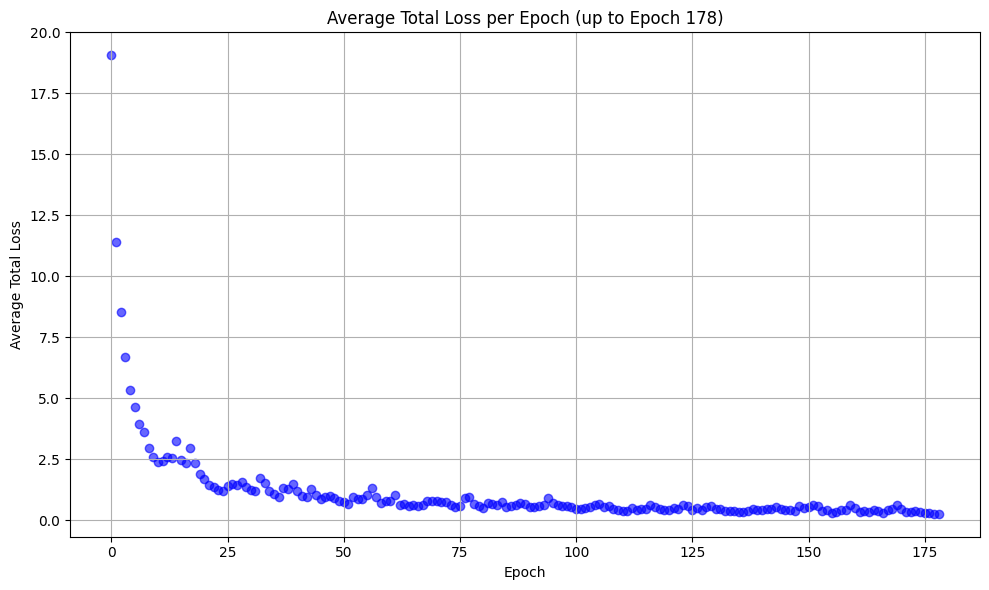

In [13]:
import json
with open(training_json, "r") as f:
    data = json.load(f)

best_epoch = data["best_model"]["epoch"]

# Filter the epochs up to and including the best one
epochs_data = [e for e in data["epochs"] if e["epoch"] <= best_epoch]

# Calculate total training time
total_time = sum(e["duration"] for e in epochs_data)
print(f"Total training time up to epoch {best_epoch}: {format_fuzzy_time(total_time)}")

# Extract data for plotting
epoch_nums = [e["epoch"] for e in epochs_data]
avg_losses = [e["avg_total_loss"] for e in epochs_data]

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(epoch_nums, avg_losses, color='blue', alpha=0.6)
plt.title(f'Average Total Loss per Epoch (up to Epoch {best_epoch})')
plt.xlabel('Epoch')
plt.ylabel('Average Total Loss')
plt.grid(True)
plt.tight_layout()
plt.show()